## PRISM data not concatenating correctly for all sites

## Processing Sensor Data from Catalina Jemez CZO Green Pit 3
Marc Berghouse 9/19/2020

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- Not sure how to deal with the A and B sensor values. Right now, if the dates for A and B don't overlap, I am combining the data in a new colum, then deleting the A and B columns. If the dates do overlap, I just leave both A and B columns in the dataframe
- I'm not sure which water potential values are unrealistic
- Unsure about O2 mask

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
infile1 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2015.csv"
infile2 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2016.csv"
infile3 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2017.csv"
infile4 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2018.csv"
infile5 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2015.csv"
infile6 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2016.csv"
infile7 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2017.csv"
infile8 = "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2018.csv"
infile9 = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"


df1 = pd.read_csv(infile1, na_values='NAN',  parse_dates=[0], index_col=0) 
df2 = pd.read_csv(infile2, na_values='NAN',  parse_dates=[0], index_col=0) 
df3 = pd.read_csv(infile3, na_values='NAN',  parse_dates=[0], index_col=0) 
df4 = pd.read_csv(infile4, na_values='NAN',  parse_dates=[0], index_col=0) 
df5 = pd.read_csv(infile5, na_values='NAN',  parse_dates=[0], index_col=0) 
df6 = pd.read_csv(infile6, na_values='NAN',  parse_dates=[0], index_col=0) 
df7 = pd.read_csv(infile7, na_values='NAN',  parse_dates=[0], index_col=0) 
df8 = pd.read_csv(infile8, na_values='NAN',  parse_dates=[0], index_col=0) 
df9 = pd.read_csv(infile9, na_values=['NAN',-9999,-99999], skiprows=10, parse_dates=[0], index_col=0) 


C:\Users\marcb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\marcb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
#drop metadata rows

df1=df1.drop(['MST'])
df2=df2.drop(['MST'])
df3=df3.drop(['MST'])
df4=df4.drop(['MST'])
df5=df5.drop(['MST'])
df6=df6.drop(['MST'])
df7=df7.drop(['MST'])
df8=df8.drop(['MST'])

df4

,TempSO1(2cm),TempSO2(10cm),TempSO3(30cm),TempSO4(60cm),O2soil1(2cm),O2soil2(10cm),O2soil3(30cm),O2soil4(60cm),CO2soil1(2cm),CO2soil2(10cm),CO2soil3(30cm),CO2soil4(60cm)
TIMESTAMP,,,,,,,,,,,,
1/1/2018 0:00,-0.942,0.295,2.02,6.38,20.138,19.13,20.251,19.601,707.87,1295.9,2134.969,2684.111
1/1/2018 0:15,-0.97,0.294,2.02,6.379,20.131,19.13,20.251,19.601,712.413,1296.99,2141.692,2685.383
1/1/2018 0:30,-0.994,0.296,2.02,6.38,20.125,19.13,20.251,19.602,708.234,1294.174,2138.058,2697.558
1/1/2018 0:45,-1.003,0.299,2.02,6.379,20.124,19.129,20.251,19.602,712.868,1299.716,2148.052,2714.094
1/1/2018 1:00,-1.017,0.302,2.018,6.377,20.126,19.129,20.252,19.602,712.686,1294.991,2137.876,2664.667
...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2018 22:45,-0.475,0.317,1.695,5.805,19.359,18.379,19.283,19.140,2346.329,2656.904,2972.404,2513.447
12/31/2018 23:00,-0.475,0.316,1.695,5.805,19.358,18.373,19.282,19.139,2352.046,2657.607,2969.765,2507.466
12/31/2018 23:15,-0.473,0.317,1.695,5.805,19.359,18.374,19.283,19.140,2341.077,2655.349,2986.860,2508.020


In [3]:
#df9=df9.loc[0:4]
pd.set_option('display.max_columns', None)

df6

,WP1(10cm),WP2(30cm),TempMPS1(10cm),TempMPS2(30cm),VWC1(10cm),VWC2(30cm),VWC3(60cm),VWC4(135cm),EC1(10cm),EC2(30cm),EC3(60cm),EC4(135cm),Temp5TE1(10cm),Temp5TE2(30cm),Temp5TE3(60cm),Temp5TE4(135cm)
TIMESTAMP,,,,,,,,,,,,,,,,
1/1/2016 0:00,-16.7,-10.8,0.8,1,0.15,0.1,0.077,0.057,0.04,0.01,0.02,0,0.5,1.4,2.4,5.9
1/1/2016 0:15,-16.6,-10.8,0.8,1,0.15,0.1,0.077,0.057,0.04,0.01,0.02,0.01,0.5,1.5,2.5,5.9
1/1/2016 0:30,-16.7,-10.8,0.8,1,0.15,0.101,0.077,0.057,0.04,0,0.01,0,0.5,1.4,2.4,5.9
1/1/2016 0:45,-16.7,-10.8,0.8,1,0.15,0.1,0.078,0.057,0.04,0.01,0.02,0.01,0.5,1.4,2.4,5.9
1/1/2016 1:00,-16.7,-10.8,0.8,1,0.15,0.1,0.077,0.057,0.04,0.01,0.02,0,0.5,1.5,2.4,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2016 22:45,-56.1,-69.4,0.5,0.9,0.08,-9999,0.042,-9999,0.03,-9999,724.2,-9999,0.1,-9999,2.6,-9999
12/31/2016 23:00,-56.2,-69.9,0.5,0.9,0.08,-9999,0.041,-9999,0.02,-9999,741.5,-9999,0.1,-9999,2.7,-9999
12/31/2016 23:15,-56.4,-69.8,0.5,0.9,0.08,-9999,0.042,-9999,0.03,-9999,675.3,-9999,0.1,-9999,2.6,-9999


In [4]:
df7

,WP1(10cm),WP2(30cm),TempMPS1(10cm),TempMPS2(30cm),VWC1(10cm),VWC3(60cm),VWC1b(10cm),VWC2b(30cm),VWC3b(60cm),VWC4b(135cm),EC1(10cm),EC3(60cm),EC1b(10cm),EC2b(30cm),EC3b(60cm),EC4b(135cm),Temp5TE1(10cm),Temp5TE3(60cm),Temp5TE1b(10cm),Temp5TE2b(30cm),Temp5TE3b(60cm),Temp5TE4b(135cm)
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,
1/1/2017 0:00,-56.1,-69.3,0.5,0.9,0.08,0.041,-9999,-9999,-9999,-9999,0.02,716,-9999,-9999,-9999,-9999,0.1,2.7,-9999,-9999,-9999,-9999
1/1/2017 0:15,-56.5,-69.6,0.5,0.9,0.08,0.042,-9999,-9999,-9999,-9999,0.02,710.2,-9999,-9999,-9999,-9999,0.1,2.6,-9999,-9999,-9999,-9999
1/1/2017 0:30,-56,-69.6,0.5,0.9,0.08,0.042,-9999,-9999,-9999,-9999,0.03,743.5,-9999,-9999,-9999,-9999,0.1,2.7,-9999,-9999,-9999,-9999
1/1/2017 0:45,-56.4,-69.2,0.5,0.9,0.08,0.042,-9999,-9999,-9999,-9999,0.03,703.7,-9999,-9999,-9999,-9999,0.1,2.7,-9999,-9999,-9999,-9999
1/1/2017 1:00,-56.2,-69.5,0.5,0.9,0.08,0.042,-9999,-9999,-9999,-9999,0.02,683,-9999,-9999,-9999,-9999,0.1,2.6,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2017 22:45,-9999,-9999,-0.3,-0.1,0.067,0.044,-9999,0.041,0.036,0.025,0.02,723.6,0,0.01,0,-9999,-0.5,1.9,-9999,0.3,2,-9999
12/31/2017 23:00,-9999,-9999,-0.3,-0.1,0.067,0.045,-9999,0.041,0.036,0.026,0.02,701.6,0,0.01,0,-9999,-0.6,1.9,-9999,0.2,1.9,-9999
12/31/2017 23:15,-9999,-9999,-0.3,-0.1,0.067,0.044,-9999,0.041,0.036,0.026,0.02,731.5,0,0.01,0,-9999,-0.5,1.9,-9999,0.3,2,-9999


In [5]:
#Merge dataframes, rename columns, mask whole dataframe, create new columns

df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9], sort=False)

df.columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100', 'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa', 'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoistureA_10cm.m3m3', 'SoilMoistureA_30cm.m3m3', 'SoilMoistureA_60cm.m3m3', 'SoilMoistureA_135cm.m3m3', 'BulkECA_10cm.dS/m', 'BulkECA_30cm.dS/m', 'BulkECA_60cm.dS/m', 'BulkECA_135cm.dS/m', 'Decagon5TETempA_10cm.deg.C','Decagon5TETempA_30cm.deg.C', 'Decagon5TETempA_60cm.deg.C', 'Decagon5TETempA_135cm.deg.C', 'SoilMoistureB_10cm.m3m3', 'SoilMoistureB_30cm.m3m3', 'SoilMoistureB_60cm.m3m3', 'SoilMoistureB_135cm.m3m3', 'BulkECB_10cm.dS/m', 'BulkECB_30cm.dS/m', 'BulkECB_60cm.dS/m', 'BulkECB_135cm.dS/m', 'Decagon5TETempB_10cm.deg.C', 'Decagon5TETempB_30cm.deg.C', 'Decagon5TETempB_60cm.deg.C', 'Decagon5TETempB_135cm.deg.C','PRISM_precim.mm'  ]

df=df.astype(float)
df['WaterPotential_10cm.kPa']=abs(df['WaterPotential_10cm.kPa'])
df['WaterPotential_30cm.kPa']=abs(df['WaterPotential_30cm.kPa'])
df.mask(df<=-0.01, inplace=True)
df=df.fillna(value=0)

#df['SoilMoisture_10cm.m3m3']=df['SoilMoistureA_10cm.m3m3']+df['SoilMoistureB_10cm.m3m3']
df['SoilMoisture_30cm.m3m3']=df['SoilMoistureA_30cm.m3m3']+df['SoilMoistureB_30cm.m3m3']
df['SoilMoisture_135cm.m3m3']=df['SoilMoistureA_135cm.m3m3']+df['SoilMoistureB_135cm.m3m3']
#df['Decagon5TETemp_10cm.deg.C']=df['Decagon5TETempA_10cm.deg.C']+df['Decagon5TETempB_10cm.deg.C']
df['Decagon5TETemp_30cm.deg.C']=df['Decagon5TETempA_30cm.deg.C']+df['Decagon5TETempB_30cm.deg.C']
#df['Decagon5TETemp_60cm.deg.C']=df['Decagon5TETempA_60cm.deg.C']+df['Decagon5TETempB_60cm.deg.C']
df['Decagon5TETemp_135cm.deg.C']=df['Decagon5TETempA_135cm.deg.C']+df['Decagon5TETempB_135cm.deg.C']
#df['BulkEC_10cm.dS/m']=df['BulkECA_10cm.dS/m']+df['BulkECB_10cm.dS/m']
df['BulkEC_30cm.dS/m']=df['BulkECA_30cm.dS/m']+df['BulkECB_30cm.dS/m']
#df['BulkEC_60cm.dS/m']=df['BulkECA_60cm.dS/m']+df['BulkECB_60cm.dS/m']
df['BulkEC_135cm.dS/m']=df['BulkECA_135cm.dS/m']+df['BulkECB_135cm.dS/m']

df

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,WaterPotential_10cm.kPa,WaterPotential_30cm.kPa,DecagonMPS6Temp_10cm.deg.C,DecagonMPS6Temp_30cm.deg.C,SoilMoistureA_10cm.m3m3,SoilMoistureA_30cm.m3m3,SoilMoistureA_60cm.m3m3,SoilMoistureA_135cm.m3m3,BulkECA_10cm.dS/m,BulkECA_30cm.dS/m,BulkECA_60cm.dS/m,BulkECA_135cm.dS/m,Decagon5TETempA_10cm.deg.C,Decagon5TETempA_30cm.deg.C,Decagon5TETempA_60cm.deg.C,Decagon5TETempA_135cm.deg.C,SoilMoistureB_10cm.m3m3,SoilMoistureB_30cm.m3m3,SoilMoistureB_60cm.m3m3,SoilMoistureB_135cm.m3m3,BulkECB_10cm.dS/m,BulkECB_30cm.dS/m,BulkECB_60cm.dS/m,BulkECB_135cm.dS/m,Decagon5TETempB_10cm.deg.C,Decagon5TETempB_30cm.deg.C,Decagon5TETempB_60cm.deg.C,Decagon5TETempB_135cm.deg.C,PRISM_precim.mm,SoilMoisture_30cm.m3m3,SoilMoisture_135cm.m3m3,Decagon5TETemp_30cm.deg.C,Decagon5TETemp_135cm.deg.C,BulkEC_30cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 10:45,3.522,6.305,8.858,10.666,20.448,20.207,20.350,19.998,1160.837,2033.241,2487.021,2837.827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 11:00,3.954,6.628,9.214,10.981,20.814,20.899,20.711,20.348,1157.620,2034.950,2521.328,2811.412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 11:15,4.187,6.733,9.310,11.045,20.815,21.257,20.740,20.345,1141.772,2041.276,2480.007,2805.450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 11:30,4.396,6.811,9.374,11.093,20.809,21.256,20.735,20.348,1150.749,2033.742,2500.863,2814.514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
10/23/2015 11:45,4.594,6.865,9.417,11.125,20.794,21.249,20.712,20.371,1146.294,2046.604,2501.021,2815.939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-28 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.33,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-29 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.19,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-30 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#More corrections to whole DataFrame

df.mask(df==0.000, inplace=True)
df

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,WaterPotential_10cm.kPa,WaterPotential_30cm.kPa,DecagonMPS6Temp_10cm.deg.C,DecagonMPS6Temp_30cm.deg.C,SoilMoistureA_10cm.m3m3,SoilMoistureA_30cm.m3m3,SoilMoistureA_60cm.m3m3,SoilMoistureA_135cm.m3m3,BulkECA_10cm.dS/m,BulkECA_30cm.dS/m,BulkECA_60cm.dS/m,BulkECA_135cm.dS/m,Decagon5TETempA_10cm.deg.C,Decagon5TETempA_30cm.deg.C,Decagon5TETempA_60cm.deg.C,Decagon5TETempA_135cm.deg.C,SoilMoistureB_10cm.m3m3,SoilMoistureB_30cm.m3m3,SoilMoistureB_60cm.m3m3,SoilMoistureB_135cm.m3m3,BulkECB_10cm.dS/m,BulkECB_30cm.dS/m,BulkECB_60cm.dS/m,BulkECB_135cm.dS/m,Decagon5TETempB_10cm.deg.C,Decagon5TETempB_30cm.deg.C,Decagon5TETempB_60cm.deg.C,Decagon5TETempB_135cm.deg.C,PRISM_precim.mm,SoilMoisture_30cm.m3m3,SoilMoisture_135cm.m3m3,Decagon5TETemp_30cm.deg.C,Decagon5TETemp_135cm.deg.C,BulkEC_30cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 10:45,3.522,6.305,8.858,10.666,20.448,20.207,20.350,19.998,1160.837,2033.241,2487.021,2837.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:00,3.954,6.628,9.214,10.981,20.814,20.899,20.711,20.348,1157.620,2034.950,2521.328,2811.412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:15,4.187,6.733,9.310,11.045,20.815,21.257,20.740,20.345,1141.772,2041.276,2480.007,2805.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:30,4.396,6.811,9.374,11.093,20.809,21.256,20.735,20.348,1150.749,2033.742,2500.863,2814.514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:45,4.594,6.865,9.417,11.125,20.794,21.249,20.712,20.371,1146.294,2046.604,2501.021,2815.939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.25,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.33,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.19,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


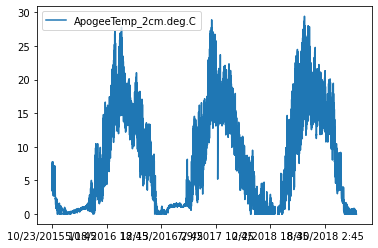

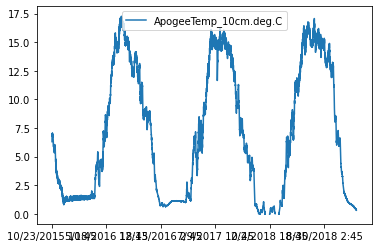

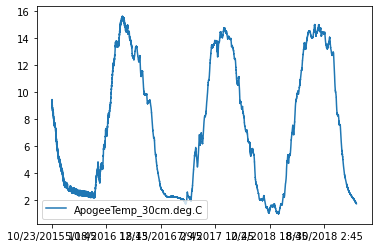

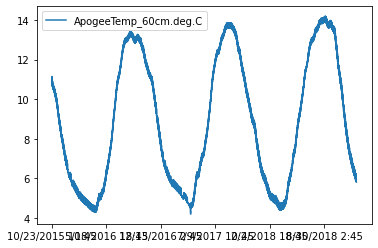

In [7]:
#Plot Apogee Temp

plt.show()
df.plot(use_index=True, y='ApogeeTemp_2cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_10cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_30cm.deg.C')
df.plot(use_index=True, y='ApogeeTemp_60cm.deg.C')


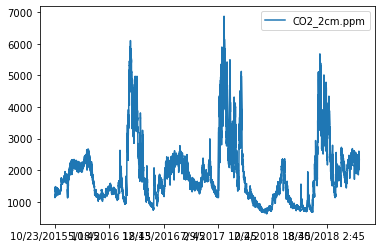

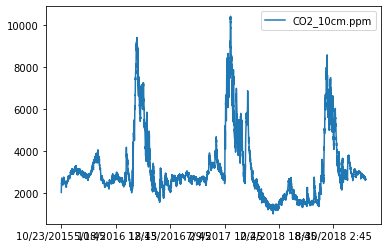

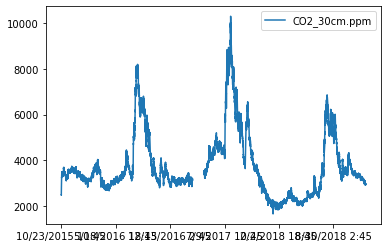

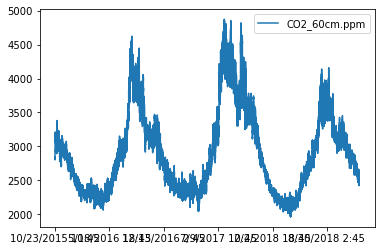

In [8]:
#Plot CO2 

plt.show()
df.plot(use_index=True, y='CO2_2cm.ppm')
df.plot(use_index=True, y='CO2_10cm.ppm')
df.plot(use_index=True, y='CO2_30cm.ppm')
df.plot(use_index=True, y='CO2_60cm.ppm')



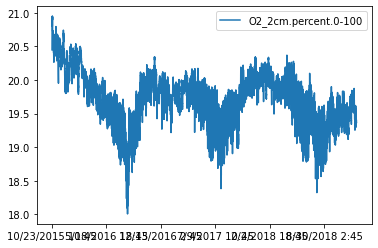

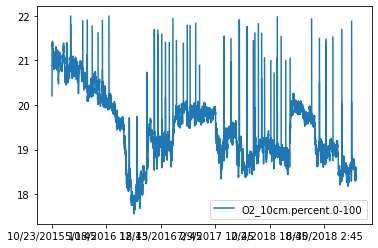

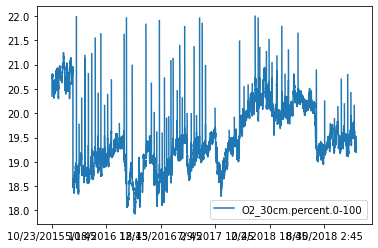

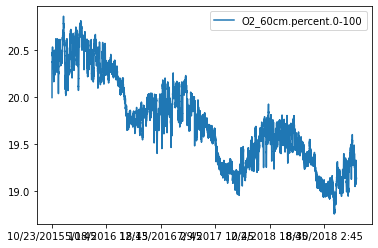

In [9]:
#Plot O2
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=22, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=22, inplace=True)
plt.show()
df.plot(use_index=True, y='O2_2cm.percent.0-100')
df.plot(use_index=True, y='O2_10cm.percent.0-100')
df.plot(use_index=True, y='O2_30cm.percent.0-100')
df.plot(use_index=True, y='O2_60cm.percent.0-100')


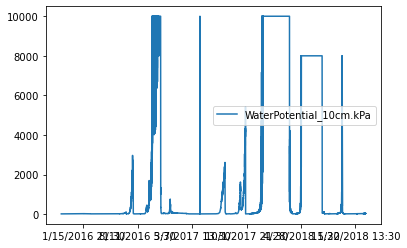

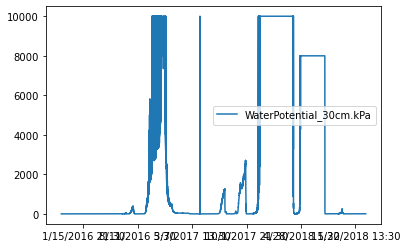

In [10]:
#Water potential has negative values, which I have masked out of the df. 
#I am thinking of taking the absolute value before masking the df.

plt.show()
df.plot(use_index=True, y='WaterPotential_10cm.kPa')
df.plot(use_index=True, y='WaterPotential_30cm.kPa')

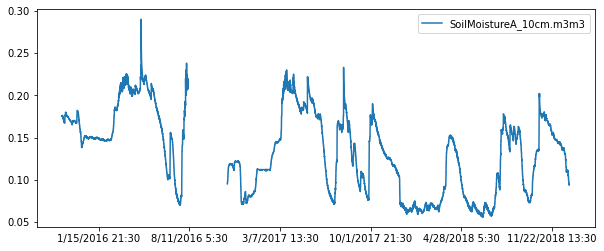

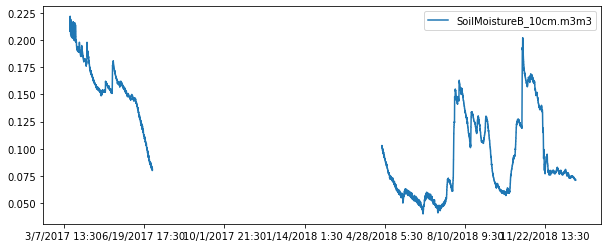

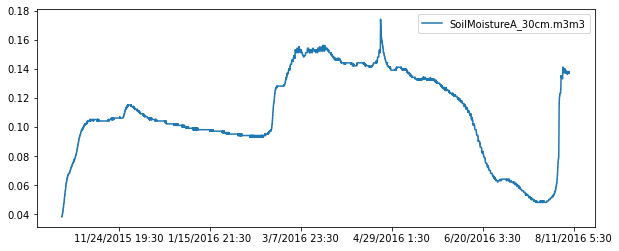

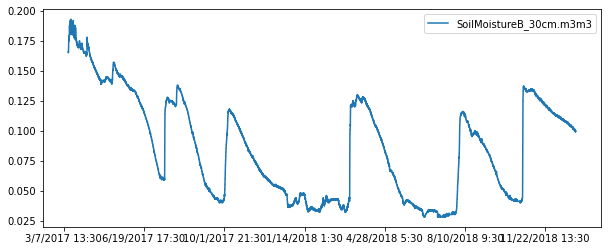

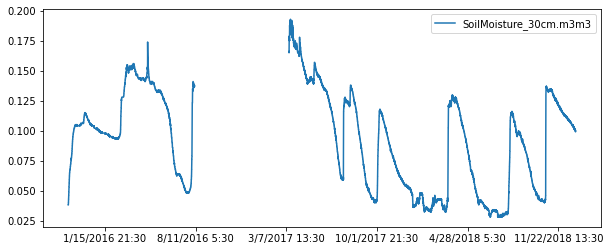

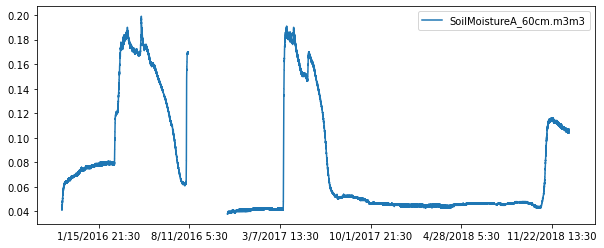

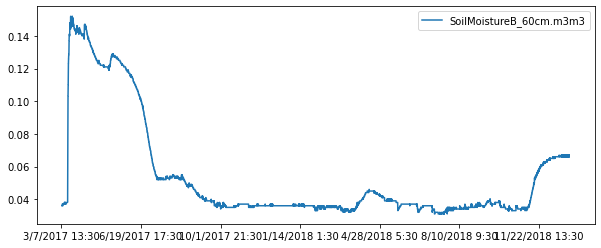

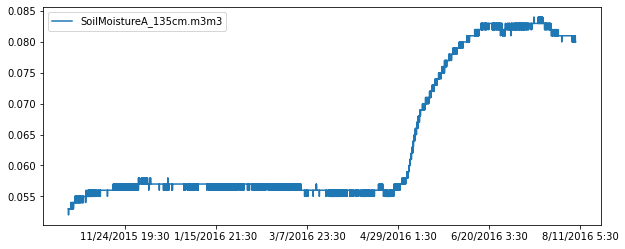

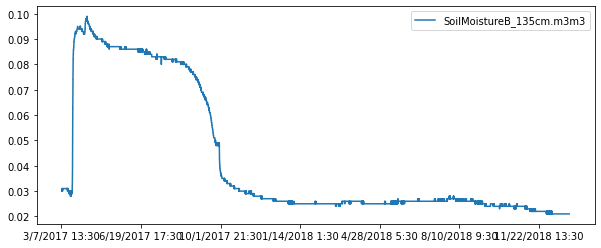

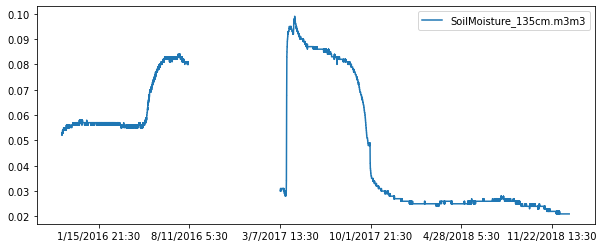

In [11]:
#Plot Soil Moisture
#I'm not sure what A and B correspond to. It seems around 2017 the A sensors were replaced with B sensors, so I have created new columns where the A and B sensor data is combined.
#Soil moisture at 30cm cannot be combined, because the dates for sensors A and B overlap

plt.show()
df.plot(use_index=True, y='SoilMoistureA_10cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_10cm.m3m3', figsize=(10,4))
#df.plot(use_index=True, y='SoilMoisture_10cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_30cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_30cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoisture_30cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_60cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_60cm.m3m3', figsize=(10,4))
#df.plot(use_index=True, y='SoilMoisture_60cm.m3m3', figsize=(10,4))


df.plot(use_index=True, y='SoilMoistureA_135cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoistureB_135cm.m3m3', figsize=(10,4))
df.plot(use_index=True, y='SoilMoisture_135cm.m3m3', figsize=(10,4))




In [12]:
df=df.drop(columns='SoilMoistureA_30cm.m3m3')
df=df.drop(columns='SoilMoistureB_30cm.m3m3')

df=df.drop(columns='SoilMoistureA_135cm.m3m3')
df=df.drop(columns='SoilMoistureB_135cm.m3m3')



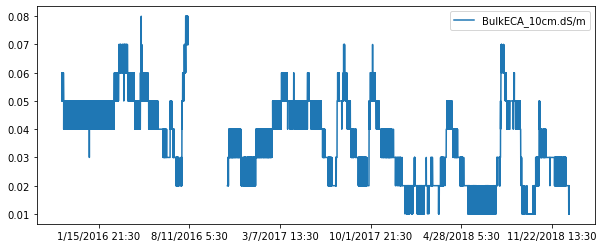

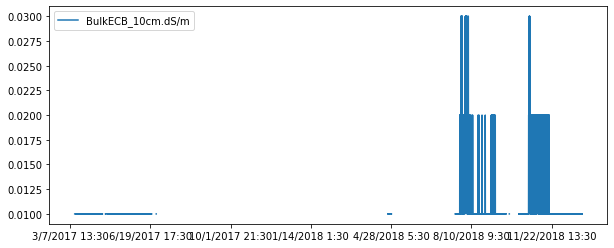

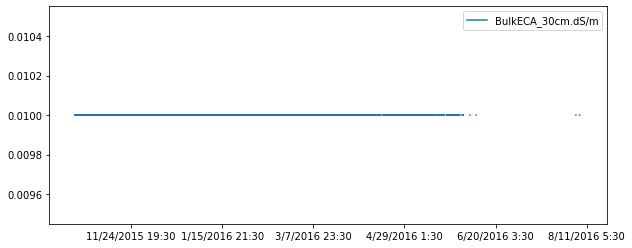

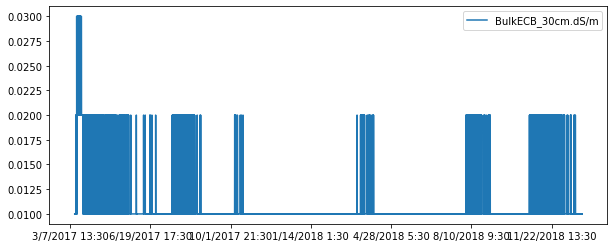

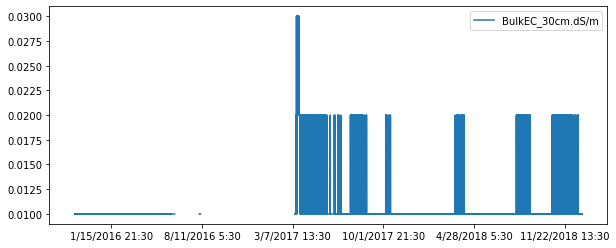

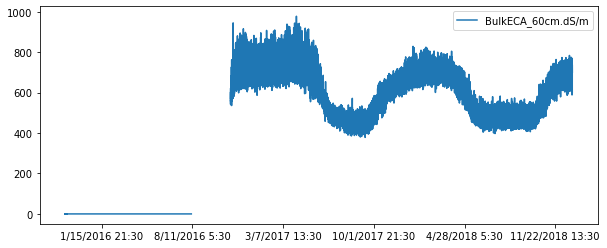

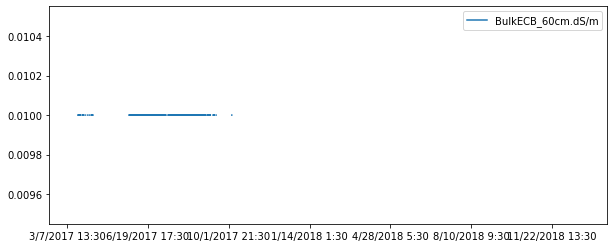

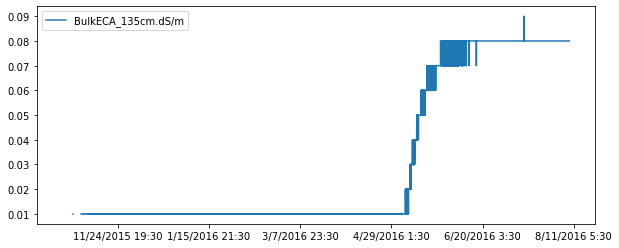

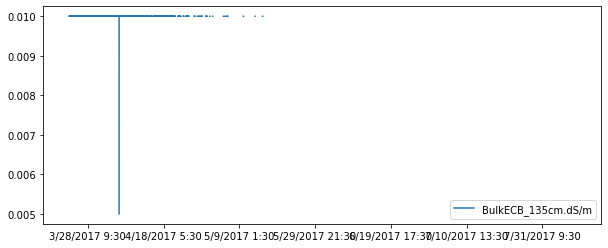

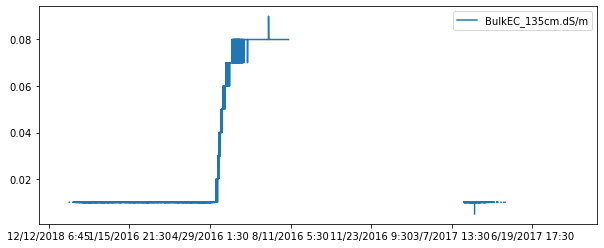

In [13]:
#Plot Bulk EC

plt.show()
df.plot(use_index=True, y='BulkECA_10cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_10cm.dS/m', figsize=(10,4))
#df.plot(use_index=True, y='BulkEC_10cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_30cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_30cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_30cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_60cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_60cm.dS/m', figsize=(10,4))
#df.plot(use_index=True, y='BulkEC_60cm.dS/m', figsize=(10,4))

df.plot(use_index=True, y='BulkECA_135cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkECB_135cm.dS/m', figsize=(10,4))
df.plot(use_index=True, y='BulkEC_135cm.dS/m', figsize=(10,4))


In [14]:

df=df.drop(columns='BulkECA_30cm.dS/m')
df=df.drop(columns='BulkECB_30cm.dS/m')
df=df.drop(columns='BulkECA_135cm.dS/m')
df=df.drop(columns='BulkECB_135cm.dS/m')

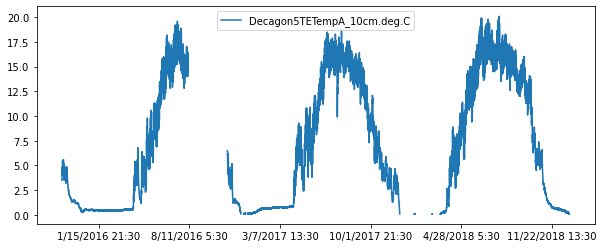

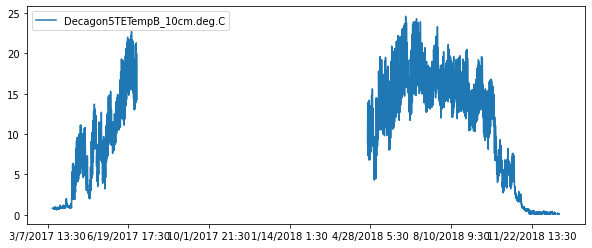

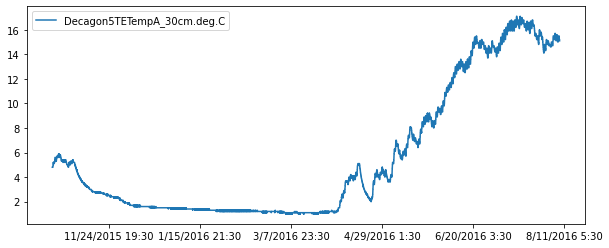

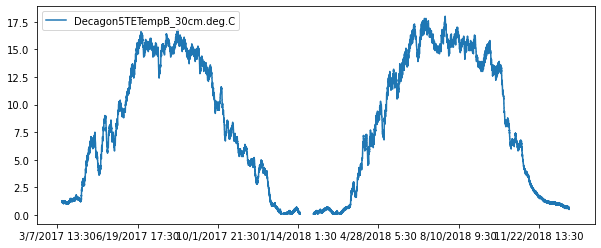

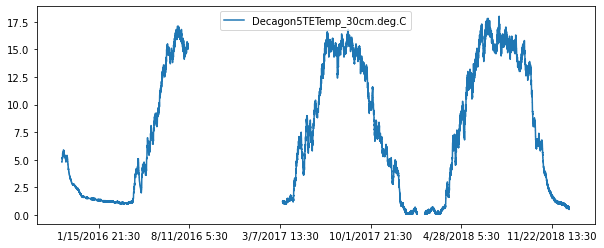

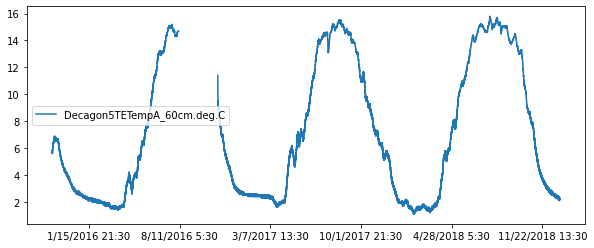

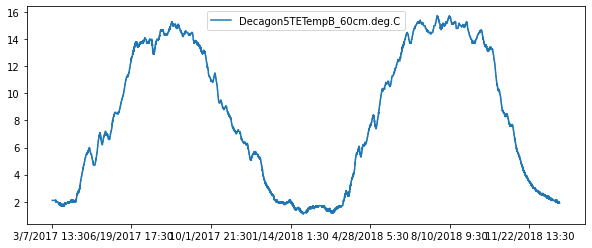

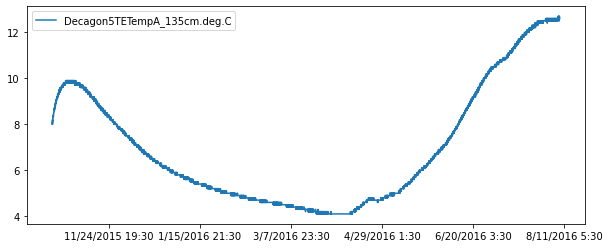

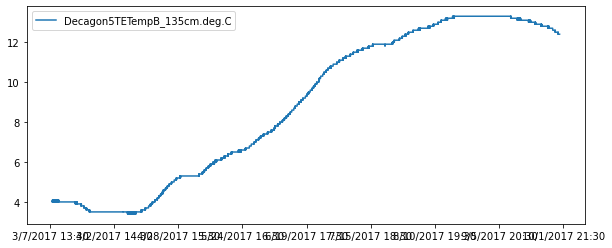

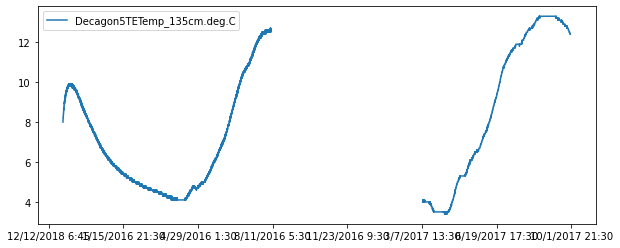

In [15]:
#Plot Decagon5TE Temps

plt.show()
df.plot(use_index=True, y='Decagon5TETempA_10cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_10cm.deg.C', figsize=(10,4))
#df.plot(use_index=True, y='Decagon5TETemp_10cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_30cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_30cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_30cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_60cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_60cm.deg.C', figsize=(10,4))
#df.plot(use_index=True, y='Decagon5TETemp_60cm.deg.C', figsize=(10,4))


df.plot(use_index=True, y='Decagon5TETempA_135cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETempB_135cm.deg.C', figsize=(10,4))
df.plot(use_index=True, y='Decagon5TETemp_135cm.deg.C', figsize=(10,4))




In [16]:
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_135cm.deg.C')
df=df.drop(columns='Decagon5TETempA_10cm.deg.C')
df=df.drop(columns='Decagon5TETempA_30cm.deg.C')
df=df.drop(columns='Decagon5TETempA_60cm.deg.C')
df=df.drop(columns='Decagon5TETempA_135cm.deg.C')
df=df.drop(columns='Decagon5TETempB_10cm.deg.C')
df=df.drop(columns='Decagon5TETempB_30cm.deg.C')
df=df.drop(columns='Decagon5TETempB_60cm.deg.C')
df=df.drop(columns='Decagon5TETempB_135cm.deg.C')

In [17]:
output=df.copy()
today = dt.date.today()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit3_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [18]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,WaterPotential_10cm.kPa,WaterPotential_30cm.kPa,DecagonMPS6Temp_10cm.deg.C,DecagonMPS6Temp_30cm.deg.C,SoilMoistureA_10cm.m3m3,SoilMoistureA_60cm.m3m3,BulkECA_10cm.dS/m,BulkECA_60cm.dS/m,SoilMoistureB_10cm.m3m3,SoilMoistureB_60cm.m3m3,BulkECB_10cm.dS/m,BulkECB_60cm.dS/m,PRISM_precim.mm,SoilMoisture_30cm.m3m3,SoilMoisture_135cm.m3m3,BulkEC_30cm.dS/m,BulkEC_135cm.dS/m
10/23/2015 10:45,3.522,6.305,8.858,10.666,20.448,20.207,20.350,19.998,1160.837,2033.241,2487.021,2837.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:00,3.954,6.628,9.214,10.981,20.814,20.899,20.711,20.348,1157.620,2034.950,2521.328,2811.412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:15,4.187,6.733,9.310,11.045,20.815,21.257,20.740,20.345,1141.772,2041.276,2480.007,2805.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:30,4.396,6.811,9.374,11.093,20.809,21.256,20.735,20.348,1150.749,2033.742,2500.863,2814.514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/23/2015 11:45,4.594,6.865,9.417,11.125,20.794,21.249,20.712,20.371,1146.294,2046.604,2501.021,2815.939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.25,NaN,NaN,NaN,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.33,NaN,NaN,NaN,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.19,NaN,NaN,NaN,NaN
2018-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
